In [18]:
import nilearn as nil
import nibabel as nib
import matplotlib
from nilearn.plotting import plot_anat
from nilearn import plotting
import numpy as np
from mgen import rotation_from_angles
import matplotlib.pyplot as plt

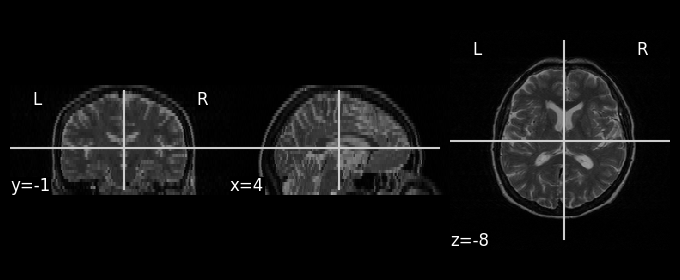

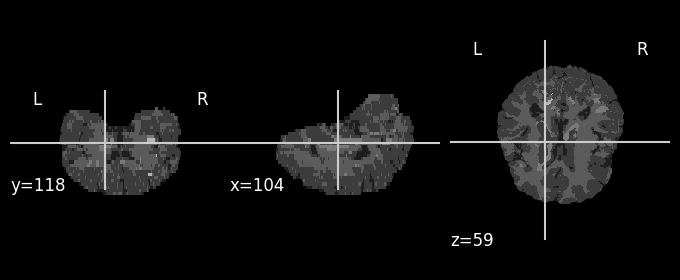

In [78]:
sub="1226"
#sub="2907"
T2w=nib.load("/scratch/beyer/3C/raw_data/T2/timepoint0/2%sDD_T2_reo.nii.gz" %sub)
anat=plot_anat(T2w)
WML=nib.load('/scratch/beyer/3C/BIDS/derivatives/WML/sub-%s/ses-t0/anat/sub-%s_ses-t0_WMHw.nii.gz' %(sub, sub))
plot_anat(WML)

In [79]:
T2w.affine

array([[  -0.9375   ,    0.       ,    0.       ,  119.53125  ],
       [   0.       ,    0.9375   ,    0.       , -119.53125  ],
       [   0.       ,    0.       ,    3.5100019,  -59.6700325],
       [   0.       ,    0.       ,    0.       ,    1.       ]])

In [80]:
WML.affine

array([[0.9375    , 0.        , 0.        , 0.9375    ],
       [0.        , 0.9375    , 0.        , 0.9375    ],
       [0.        , 0.        , 3.50999999, 3.50999999],
       [0.        , 0.        , 0.        , 1.        ]])

In [103]:
print(T2w.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256  35   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.        0.9375    0.9375    3.510002  0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 119.53125
qoffset_y       : -119.53125
qoffs

### Different ways to align T2 and WML maps
Use rotational matrix and play around with it -> did not work well

In [ ]:
new_header=WML.header.copy()
sform=WML.get_sform()
sform_T2=T2w.get_sform()
data=WML.get_data()

rot=np.identity(4)
rot[0:3,0:3]=rotation_from_angles([np.pi, 0, 0], 'XYZ')
sform_trans=np.identity(4)
sform_trans[:,3]=[-119,119,0,0] #sform_T2[:,3]
sform_new=sform.dot(rot)*sform_trans

new_img = nib.nifti1.Nifti1Image(data, sform_new, header=new_header)
new_img.get_sform()
display=plot_anat(T2w)
display.add_overlay(new_img)

In [ ]:
rot=np.identity(4)
rot[0:3,0:3]=rotation_from_angles([np.pi, np.pi, np.pi], 'ZYX')

WML_affine_test=WML.affine.dot(rot)
#WML_test=WML.__class__(WML.get_data(), WML_affine_test, WML.header)
#WML_test.affine
WML_test=WML
WML_test.affine=WML_affine_test

### Different ways to align T2 and WML maps
Just rearrange data and then copy the same header as from T2w.

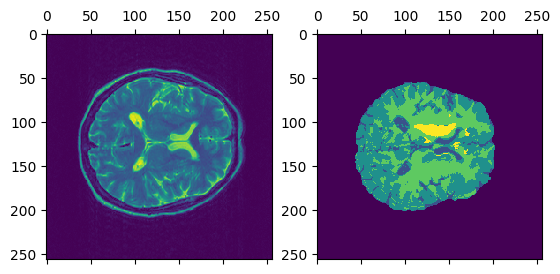

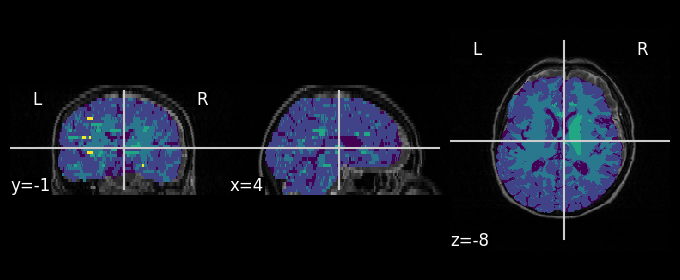

In [116]:
T2wdata=T2w.get_fdata()
WMLdata=WML.get_fdata()

#Used for most subjects:
#WMLdata_n=np.flip(np.rot90(np.rot90(np.flip(WMLdata,2))),0)

#Needs to be used for misaligned subjects:
WMLdata_n=np.flip(np.flip(np.rot90(np.rot90(WMLdata)),2),0)

#WMLdata_n=WMLdata
fig, ax = plt.subplots(1, 2)
ax[0].matshow(T2wdata[:, :, 15])

#WMLdata_n=WMLdata_n[:,:,4:35]
im = ax[1].matshow(WMLdata_n[:, :, 15])
WMLdata_n[:,:,]

#WMLdata_nn=np.zeros(np.shape(WMLdata_n))
#WMLdata_nn[:,:,0:31]=WMLdata_n

nib.save(nib.Nifti1Image(WMLdata_nn, T2w.affine),
         '/scratch/beyer/3C/BIDS/derivatives/WML/sub-%s/ses-t0/anat/sub-%s_ses-t0_WMHw_reo_new.nii.gz' %(sub,sub))

display=plot_anat(T2w)
WML_reo=nib.load('/scratch/beyer/3C/BIDS/derivatives/WML/sub-%s/ses-t0/anat/sub-%s_ses-t0_WMHw_reo_new.nii.gz' %(sub,sub))
display.add_overlay(WML_reo)



### Try coregistration with FLIRT

In [ ]:
from nipype.interfaces import fsl

sub="1226"
WMH='/scratch/beyer/3C/BIDS/derivatives/WML/sub-%s/ses-t0/anat/sub-%s_ses-t0_WMHw_reo_withflip.nii.gz' %(sub, sub)
T2wim="/scratch/beyer/3C/raw_data/T2/timepoint0/2%sDD_T2_reo.nii.gz" %sub
WMH_out='/scratch/beyer/3C/BIDS/derivatives/WML/sub-%s/ses-t0/anat/sub-%s_ses-t0_WMHw_flirt.nii.gz' %(sub, sub)
flt = fsl.FLIRT()
flt.inputs.in_file = WMH
flt.inputs.reference = T2wim
flt.inputs.dof = 6
flt.inputs.interp="nearestneighbor"
flt.inputs.output_type = "NIFTI_GZ"
flt.inputs.out_file=WMH_out
res = flt.run() 